# ASPIRE ab initio pipeline -- simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.proposals import CryoProposals
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from aspire.abinitio import CLSyncVoting
from aspire.basis import FFBBasis2D, FFBBasis3D
from aspire.classification import BFSReddyChatterjiAverager2D, RIRClass2D
from aspire.denoising import DenoiserCov2D
from aspire.noise import AnisotropicNoiseEstimator
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.reconstruction import MeanEstimator
from aspire.source import Simulation
from aspire.utils.coor_trans import (
    get_aligned_rotations,
    get_rots_mse,
    register_rotations,
)
from aspire.volume import Volume

logger = logging.getLogger(__name__)


### Parameters

In [3]:
interactive = True  # Draw blocking interactive plots?
do_cov2d = False  # Use CWF coefficients
img_size = 32  # Downsample the volume to a desired resolution
num_imgs = 1000  # How many images in our source.
n_classes = 100  # How many class averages to compute.
n_nbor = 10  # How many neighbors to stack
noise_variance = 5e-7  # Set a target noise variance
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True


### Simulation data

In [4]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"

og_v = Volume.load(vol_file, dtype=np.float64)
logger.info("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")

2022-06-16 17:35:48,797 INFO /home/bt387/project/simple_cryoem/data/emdb/emd_2660.map with dtype float32 loaded as <class 'numpy.float64'>
2022-06-16 17:35:48,907 INFO Original volume map data shape: (1, 360, 360, 360) dtype:float64


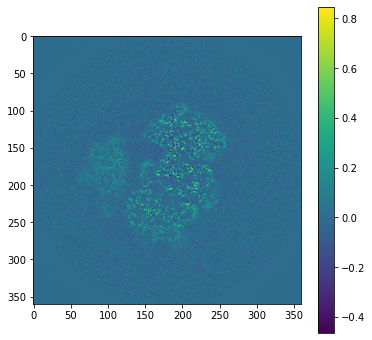

In [5]:
plt.imshow(og_v[0,180]); plt.colorbar()

In [6]:
logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution

2022-06-16 17:35:49,154 INFO Downsampling to (32, 32, 32)


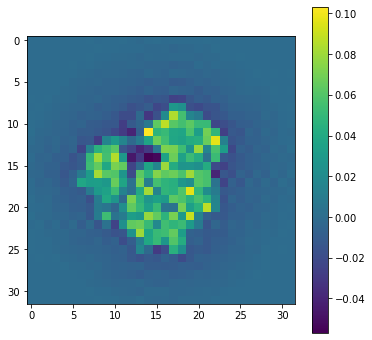

In [7]:
plt.imshow(v[0,16]); plt.colorbar()

In [8]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v.mrc', overwrite=True) as mrc:
        mrc.set_data(og_v._data.astype(np.float32))

In [9]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

In [10]:
# Then create a filter based on that variance
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0


custom_noise_filter = FunctionFilter(noise_function)

In [11]:
logger.info("Initialize CTF filters.")
# Create some CTF effects
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]

2022-06-16 17:35:57,944 INFO Initialize CTF filters.


In [186]:
v.resolution

32

2022-06-16 17:35:57,972 INFO Creating Simulation with 1000 images.
2022-06-16 17:35:57,974 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-16 17:35:57,984 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-16 17:35:57,985 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-16 17:35:57,986 INFO Trying NFFT backend finufft
2022-06-16 17:35:57,991 INFO NFFT backend finufft usable.
2022-06-16 17:35:57,992 INFO Trying NFFT backend cufinufft
2022-06-16 17:35:57,994 INFO NFFT backend cufinufft not usable:
	No module named 'pycuda'
2022-06-16 17:35:57,994 INFO Trying NFFT backend pynfft
2022-06-16 17:35:57,995 INFO NFFT backend pynfft not usable:
	No module named 'pynfft'
2022-06-16 17:35:57,996 INFO Selected NFFT backend = finufft.
2022-06-16 17:35:58,042 INFO Applying forward transformations in pipeline
2022-0

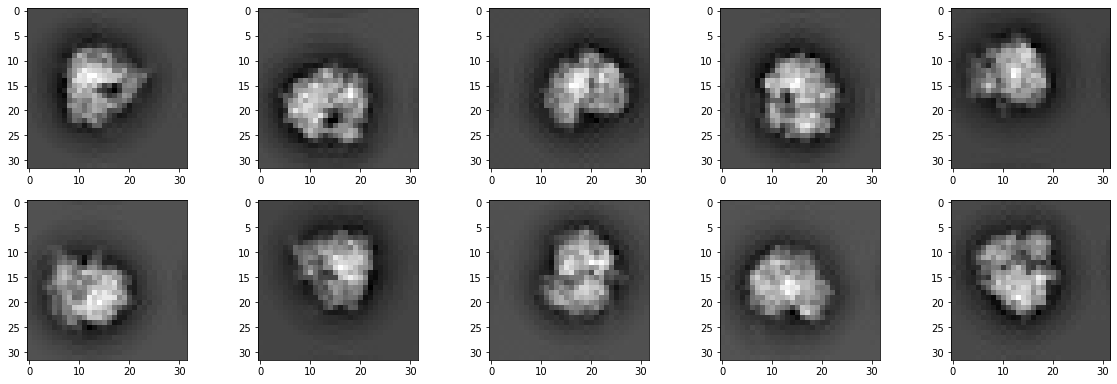

In [12]:
# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)
# Peek
if interactive:
    src.images(0, 10).show()


In [13]:
# Use phase_flip to attempt correcting for CTF.
logger.info("Perform phase flip to input images.")
#src.phase_flip()


2022-06-16 17:36:08,112 INFO Perform phase flip to input images.


In [14]:
# Estimate the noise and `Whiten` based on the estimated noise
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
#src.whiten(aiso_noise_estimator.filter)

2022-06-16 17:36:18,370 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-16 17:36:18,376 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-16 17:36:18,600 INFO Applying forward transformations in pipeline
2022-06-16 17:36:18,601 INFO All forward transformations applied
2022-06-16 17:36:18,604 INFO Loaded 512 images
2022-06-16 17:36:18,613 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-16 17:36:18,616 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-16 17:36:18,813 INFO Applying forward transformations in pipeline
2022-06-16 17:36:18,814 INFO All forward transformations applied
2022-06-16 17:36:18,814 INFO Loaded 488 images


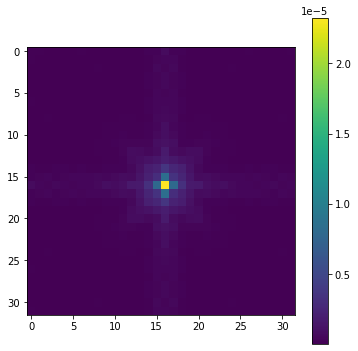

2022-06-16 17:36:44,500 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-16 17:36:44,501 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-16 17:36:44,529 INFO Applying forward transformations in pipeline
2022-06-16 17:36:44,530 INFO All forward transformations applied
2022-06-16 17:36:44,532 INFO Loaded 10 images


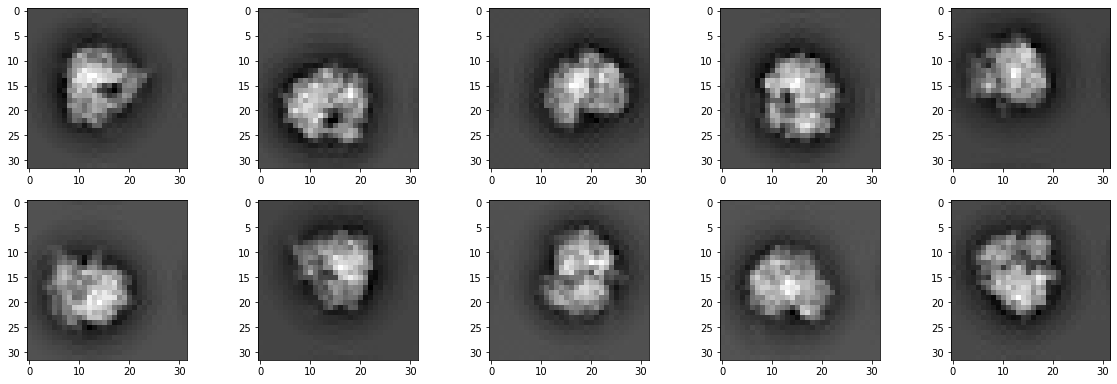

In [16]:
# Plot the noise profile for inspection
if interactive:
    plt.imshow(aiso_noise_estimator.filter.evaluate_grid(L))
    plt.colorbar()
    plt.show()

# Peek, what do the whitened images look like...
if interactive:
    src.images(0, 10).show()

In [17]:
# Cache to memory for some speedup
src.cache()

2022-06-16 17:36:47,097 INFO Caching source images
2022-06-16 17:36:47,099 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-16 17:36:47,107 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-16 17:36:47,489 INFO Applying forward transformations in pipeline
2022-06-16 17:36:47,490 INFO All forward transformations applied
2022-06-16 17:36:47,490 INFO Loaded 1000 images


### Class Averaging

In [16]:
logging.disable(logging.INFO)

2022-06-16 16:53:51,632 WARNING Left side b after removing noise in Cov2D is not positive semidefinite.
2022-06-16 16:53:51,650 WARNING Covariance matrix in Cov2D is not positive semidefinite.


100%|██████████| 100/100 [00:00<00:00, 116.78it/s]


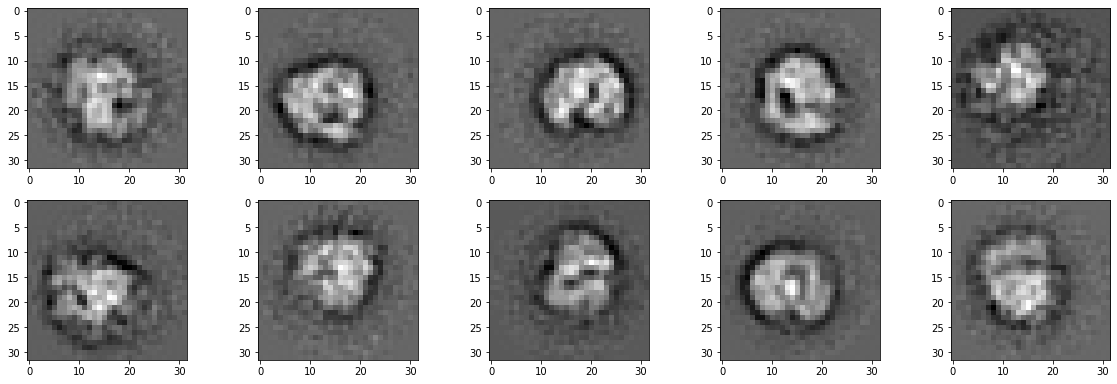

In [17]:
logger.info("Begin Class Averaging")

rir = RIRClass2D(
    src,  # Source used for classification
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=n_nbor,
    n_classes=n_classes,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    bispectrum_implementation="legacy",
    averager=None,
)

classes, reflections, distances = rir.classify()
avgs = rir.averages(classes, reflections, distances)
if interactive:
    avgs.images(0, 10).show()

### Common Line Estimation

In [18]:
logger.info("Begin Orientation Estimation")

# Stash true rotations for later comparison,
#   note this line only works with naive class selection...
true_rotations = src.rots[:n_classes]

orient_est = CLSyncVoting(avgs, n_theta=36)
# Get the estimated rotations
orient_est.estimate_rotations()
rots_est = orient_est.rotations

logger.info("Compare with known rotations")
# Compare with known true rotations
Q_mat, flag = register_rotations(rots_est, true_rotations)
regrot = get_aligned_rotations(rots_est, Q_mat, flag)
mse_reg = get_rots_mse(regrot, true_rotations)
logger.info(
    f"MSE deviation of the estimated rotations using register_rotations : {mse_reg}\n"
)

### Volume reconstruction

2022-06-16 16:56:15,359 WARNING Inconsistent types in float32 Estimator. basis: float64
2022-06-16 16:56:15,387 WARNING anufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: complex128.
2022-06-16 16:56:15,415 WARNING nufft passed inconsistent dtypes. fourier_pts: float64 forcing precision of signal data: float32.


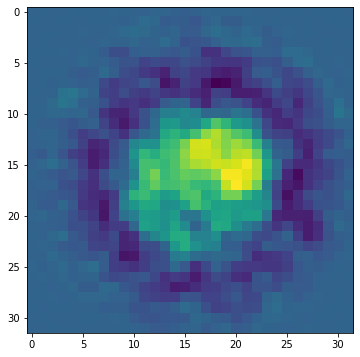

In [19]:
logger.info("Begin Volume reconstruction")

# Assign the estimated rotations to the class averages
avgs.rots = rots_est

# Create a reasonable Basis for the 3d Volume
basis = FFBBasis3D((v.resolution,) * 3, dtype=v.dtype)

# Setup an estimator to perform the back projection.
estimator = MeanEstimator(avgs, basis)

# Perform the estimation and save the volume.
estimated_volume = estimator.estimate()
fn = f"estimated_volume_n{num_imgs}_c{n_classes}_m{n_nbor}_{img_size}.mrc"
estimated_volume.save(fn, overwrite=True)

# Peek at result
if interactive:
    plt.imshow(np.sum(estimated_volume[0], axis=-1))
    plt.show()

In [34]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_aspire.mrc', overwrite=True) as mrc:
        mrc.set_data(estimated_volume._data.astype(np.float32))

### Jaxify

In [81]:
from src.projection import project

In [158]:
N = 100
nx = img_size

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)
imgs = jnp.array(src.images(0,N).data)
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
shifts = src.offsets

print(f"x_grid = {x_grid}")

2022-06-16 18:30:38,132 INFO Loading images from cache
2022-06-16 18:30:38,134 INFO Applying forward transformations in pipeline
2022-06-16 18:30:38,134 INFO All forward transformations applied
2022-06-16 18:30:38,135 INFO Loaded 100 images
x_grid = [3.07692308e-03 3.20000000e+01]


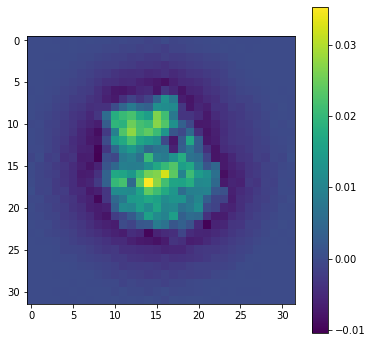

In [159]:
plt.imshow(imgs[24]); plt.colorbar()

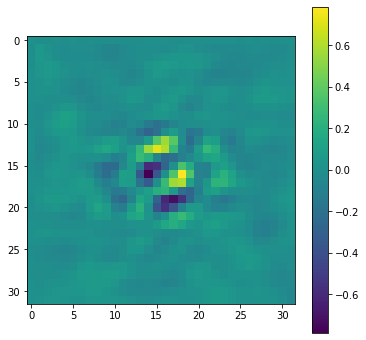

In [160]:
plt.imshow(jnp.fft.fftshift(jnp.imag(imgs_f[24]))); plt.colorbar()

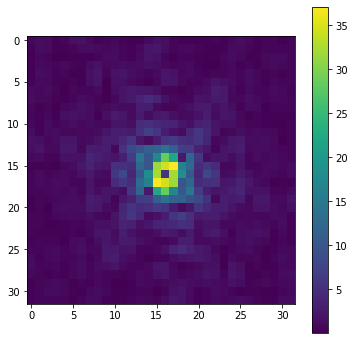

In [243]:
imgidx = 6

#vol_f = jnp.swapaxes(vol_f, 0, 2)
angles0 = jnp.array([angles[imgidx,2], angles[imgidx,1],angles[imgidx,0]])
shifts0 = jnp.array([shifts[imgidx,0], shifts[imgidx,1]])


p = project(vol_f, angles[imgidx], -shifts[imgidx]*pixel_size, None, x_grid, x_grid)
plt.imshow(jnp.fft.fftshift(jnp.abs(p.reshape([nx,nx])))); plt.colorbar()

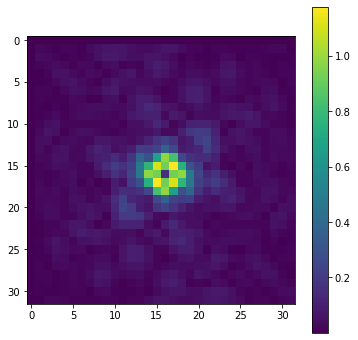

In [244]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[imgidx]))); plt.colorbar()

In [245]:
angles0

DeviceArray([1.8038058, 1.7982619, 1.7498559], dtype=float32)

In [246]:
angles1 = angles0.at[0].set(angles0[0]+jnp.pi/2+jnp.pi/8)

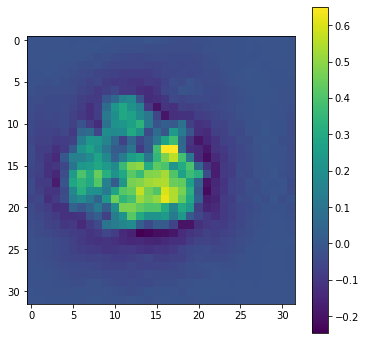

In [247]:
#vol = jnp.swapaxes(vol, 0, 2)
angles0
pr = project_spatial(vol, angles0, pixel_size, shifts0*pixel_size)
plt.imshow(pr); plt.colorbar()

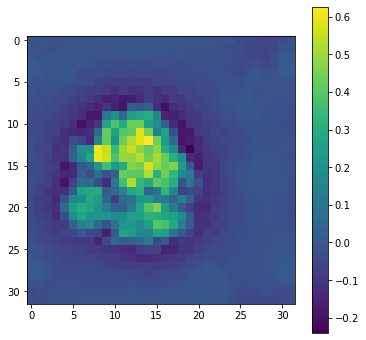

In [248]:
#vol = jnp.swapaxes(vol, 0, 2)
angles0
pr = project_spatial(vol, angles1, pixel_size, shifts0*pixel_size)
plt.imshow(pr); plt.colorbar()

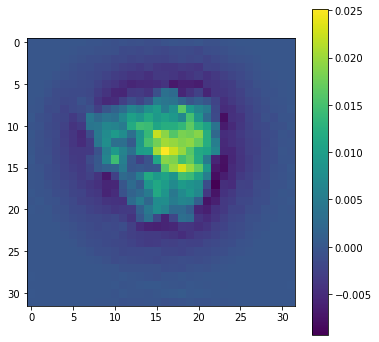

In [249]:
plt.imshow(imgs[imgidx]); plt.colorbar()